# Import data methods:
1. Reading zero-crossing file and extract time, frequency, amplitude and metadata information.(preferred)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from util.bat import *
import random
import os
import pandas as pd

# Set some Pandas options
pd.set_option('notebook_repr_html', True)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)

In [2]:
# Call extract_anabat from util.anabat to extract time, frequency, amplitude and partial metadata from zero-crossing file
info=extract_anabat('../data/P7132033.37#')  # P7132035.14#  P7132033.37#  ../data/social/S8072135.07#
info2=extract_anabat('../data/social/S8072135.07#') 

In [3]:
t=info[0]
freq=info[1]
ampl=info[2]
metadata=info[3]

In [66]:
metadata

{'date': '        ',
 'divratio': 8,
 'gps': '',
 'id': '',
 'loc': '',
 'note1': 'V4062g',
 'note2': '',
 'spec': 'SD1 Mod1',
 'species': ['PERSUB '],
 'timestamp': datetime.datetime(2015, 7, 13, 20, 33, 37, 290175)}

In [70]:
t[-1]-t[0]

11.817265999999998

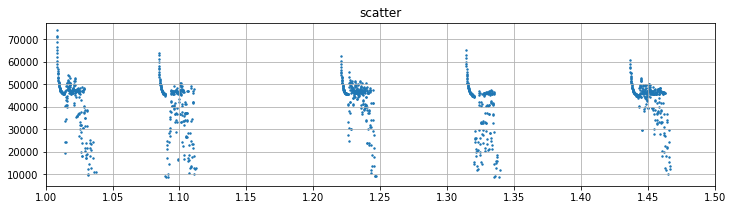

In [11]:
#visualization
plt.figure(figsize=(12,3))
plt.scatter(t, freq, s=2)
plt.xticks(np.arange(1, 1.6, 0.05))
plt.xlim(1, 1.5)
plt.title("scatter")
plt.grid()

2.Read from .csv files of time and freq that decoded using R.

In [6]:
# Read time and frequency data from a csv sample data file. 
# The data in csv file is processed using R from Bat acoustic recording (zero-crossing file) encoded by Anabat file format 132.(AnabatTools.R--see R codes for details)
import csv

call_list = list(csv.reader(open('../data/P7132033_37.csv', 'rb')))[1:]
#print call_list

# Remove noise and extract valid pulse signals 

1. Call remove_noise function from util.anabat to remove the noises of original zc file.
2. Get the returned valid pulses.
3. Use display_pulses method from util.anabat to plot a few random sample of the valid pulses.

In [7]:
# remove noise 
pulses=remove_noise(t,freq)

In [8]:
# length of pulses in a given zc file
num = len(pulses)
num 

23

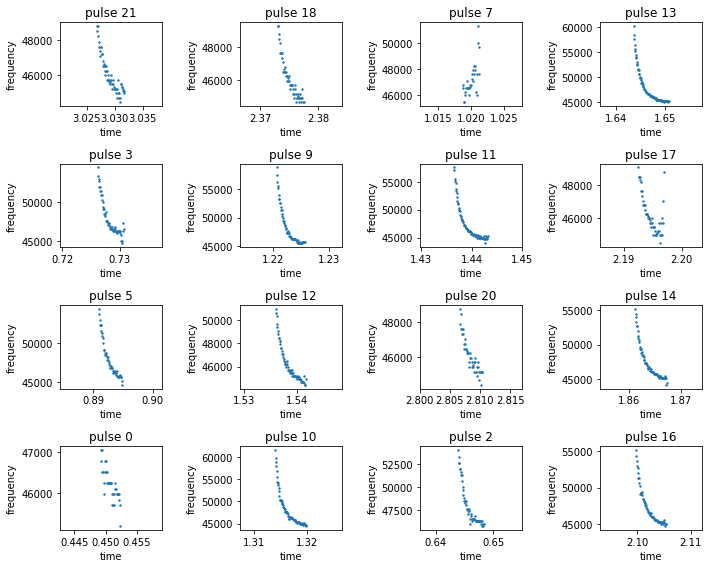

In [9]:
# plot random pulses sample
display_pulses(pulses, nrows=4, ncols=4, figsize=(10,8))

# Search abnormal labeled data files in a folder

Call get_labeled_file util method in anabat module.

In [12]:
# Example of find bat acoustic files contains social call (have "social" label in metadata)
datadir='D:\\dropbox_backup\\acoustic social auto id\\bat recordings\\transects\\2018\\cell-75\\20180715\\'
label='social'
get_labeled_file(datadir,label)

['S7152113.44#', 'S7152121.42#']

# Descriptive Analysis

15kHz-120kHz

5% of social calls.

In [13]:
data2015 = pd.read_csv('../data/2015_night.txt', sep="\t")
data2016 = pd.read_csv('../data/2016_night.txt', sep="\t")
data2017 = pd.read_csv('../data/2017_night.txt', sep="\t")
data2018 = pd.read_csv('../data/2018_night.txt', sep="\t")

In [17]:
data2018[10:30]

,Folder1,Folder2,Night,Label,Number
10,cell-100,20180725,2018/07/25,EPFU,20
11,cell-100,20180725,2018/07/25,LABO,6
12,cell-100,20180725,2018/07/25,LACI,1
13,cell-100,20180725,2018/07/25,LANO,10
14,cell-100,20180725,2018/07/25,MYSPP,1
15,cell-100,20180725,2018/07/25,NOID,7
16,cell-100,20180725,2018/07/25,PESU,2
17,cell-100,20180725,2018/07/25,foraging,1
18,cell-100,20180726,2018/07/26,EPFU,18
19,cell-100,20180726,2018/07/26,LABO,13


In [29]:
data2015['Label'].unique

<bound method Series.unique of 0          LABO
1          NOID
2          NYHU
3          PESU
4          TABR
5          LABO
6          LACI
7          LANO
8          NOID
9          NYHU
         ...   
388        PESU
389        LABO
390        LACI
391        LANO
392       MYSPP
393        NOID
394        NYHU
395        PESU
396    foraging
397      social
Name: Label, Length: 398, dtype: object>

In [21]:
def count_recordings(df, label=None):
    """
     Given a data table and the label, return the counts in this table with certain label
     label=None --- find the total recording counts
     label=social --- find the recording count for files containing 'social' label
     label=foraging --- find the recording count for files containing 'foraging' label
     label=Feeding --- find the recording count for files containing 'Feeding' label
     
     """
    if label=='social':
        count=df[df['Label'].str.contains('social')==True]['Number'].sum()
    elif label=='foraging':
        count=df[df['Label'].str.contains('foraging')==True]['Number'].sum()
    elif label=='Feeding':
        count=df[df['Label'].str.contains('Feeding')==True]['Number'].sum()
    else:
        count=df[df['Label'].str.contains('social|foraging|Feeding')==False]['Number'].sum()
    
    return count
    

In [22]:
# how many bat recordings in 2015
count_recordings(data2015)

2527

In [23]:
# how many social labeled recording in 2015
count_recordings(data2015,'social')

13

In [24]:
subt2015=count_recordings(data2015)
subt2016=count_recordings(data2016)
subt2017=count_recordings(data2017)
subt2018=count_recordings(data2018)
#total sample size
totalss=subt2015+subt2016+subt2017+subt2018
totalss

10626

In [25]:
totalsocial=count_recordings(data2015,'social')+count_recordings(data2016,'social')+count_recordings(data2017,'social')+count_recordings(data2018,'social')
totalsocial

29

In [26]:
totalforaging=count_recordings(data2015,'foraging')+count_recordings(data2016,'foraging')+count_recordings(data2017,'foraging')+count_recordings(data2018,'foraging')
totalforaging

155

In [27]:
totalfeeding=count_recordings(data2015,'Feeding')+count_recordings(data2016,'Feeding')+count_recordings(data2017,'Feeding')+count_recordings(data2018,'Feeding')
totalfeeding

12

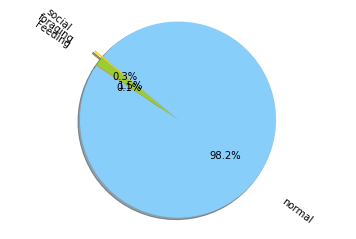

In [28]:
# Data to plot
labels = 'social', 'foraging', 'Feeding', 'normal'
sizes = [totalsocial, totalforaging, totalfeeding, totalss-totalsocial-totalforaging-totalfeeding]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,rotatelabels=True,labeldistance=1.3)
 
plt.axis('equal')
plt.show()
# social:0.3%  foraging:1.5%  Feeding:0.1%  normal:98.2% 

# Initial result for pulse clustering

In [4]:
pulses=remove_noise(t,freq)

In [29]:
type(pulses)
len(pulses)

23

In [30]:
# Find all the dy for a list of valid pulses
pulse_dy=list()
j=0
for pulse in pulses:
    i=0
    dy=list()
    for dot in pulse:
        
        if i==0:
            prev_dot=dot[1]
        else:
            dy.append(dot[1]-prev_dot)
            prev_dot=dot[1]
        i+=1
        
    pulse_dy.append(dy)
    

In [131]:
len(pulse_dy)

23

In [31]:
a=pd.DataFrame(pulse_dy[0]).describe()
a

,0
count,36.000000
mean,-51.696762
std,242.328986
min,-547.195622
25%,-262.725780
50%,0.000000
75%,0.000000
max,547.195622


In [32]:
# get mean, sd, and five-number summary features for pulses
def get_features(pulse_dy):
    features=pd.DataFrame()
    for dy in pulse_dy:
        a=pd.DataFrame(dy).describe().iloc[1:8,].T
        features=features.append(a)
    return features
    
    

In [7]:
b=get_features(pulse_dy)

In [33]:
b.iloc[8:11,]

,mean,std,min,25%,50%,75%,max
0,-272.932748,422.299066,-1730.478045,-458.791246,-135.998912,0.0,528.488852
0,-214.905634,337.745797,-1269.572577,-318.445984,-129.870130,0.0,262.725780
0,-244.200244,403.029870,-1836.969001,-302.037785,-204.157749,0.0,505.002683


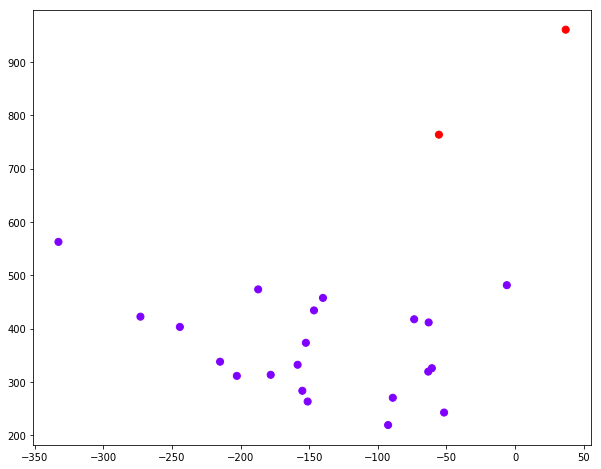

In [36]:
# Clustering a sample recording pulses using KMeans
from sklearn.cluster import KMeans
est = KMeans(2)  # 4 clusters
# X=b.iloc[:,0:2]
X=b
est.fit(X)
y_kmeans = est.predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='rainbow');

In [38]:
# mask=y_kmeans==1

# from itertools import compress
# c=list(compress(pulses, mask))
# len(c)

y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1])

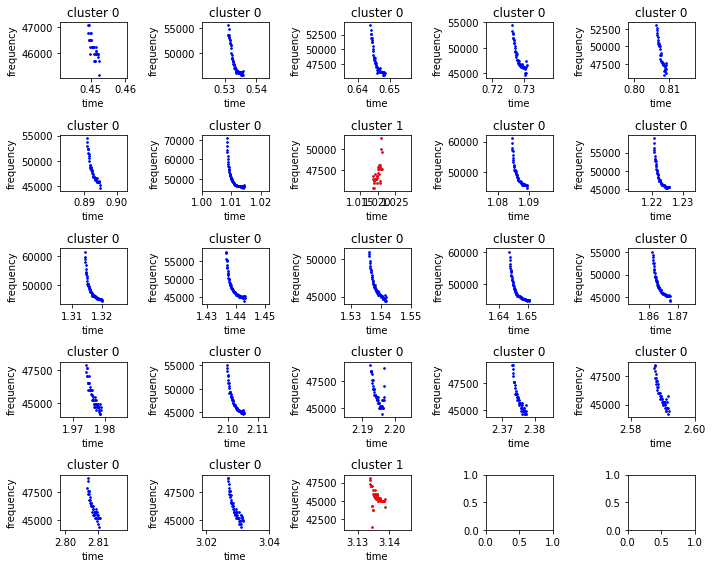

In [39]:
display_pulses(pulses,len(pulses),5,rand_flag=False, cluster=y_kmeans)